In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from skimage.color import lab2rgb
from skimage.color import rgb2lab



OUTPUT_TEMPLATE = (
    'Bayesian classifier:     {bayes_rgb:.3f}  {bayes_convert:.3f}\n'
    'kNN classifier:          {knn_rgb:.3f}  {knn_convert:.3f}\n'
    'Rand forest classifier:  {rf_rgb:.3f}  {rf_convert:.3f}\n'
)


# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 112, 0),
    'yellow': (255, 255, 0),
    'green': (0, 231, 0),
    'blue': (0, 0, 255),
    'purple': (185, 0, 185),
    'brown': (117, 60, 0),
    'pink': (255, 184, 184),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])


def plot_predictions(model, lum=67, resolution=300):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((-1, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, -1)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)


def main():
    data = pd.read_csv(sys.argv[1])
    X = data[['R', 'G', 'B']].values / 255
    y = data['Label'].values

    # TODO: create some models

    # train each model and output image of predictions
    models = [bayes_rgb_model, bayes_convert_model, knn_rgb_model, knn_convert_model, rf_rgb_model, rf_convert_model]
    for i, m in enumerate(models):  # yes, you can leave this loop in if you want.
        m.fit(X_train, y_train)
        plot_predictions(m)
        plt.savefig('predictions-%i.png' % (i,))

    print(OUTPUT_TEMPLATE.format(
        bayes_rgb=bayes_rgb_model.score(X_valid, y_valid),
        bayes_convert=bayes_convert_model.score(X_valid, y_valid),
        knn_rgb=knn_rgb_model.score(X_valid, y_valid),
        knn_convert=knn_convert_model.score(X_valid, y_valid),
        rf_rgb=rf_rgb_model.score(X_valid, y_valid),
        rf_convert=rf_convert_model.score(X_valid, y_valid),
    ))
    
def convert_colors(X):
    return rgb2lab(X)



In [3]:
data = pd.read_csv('colour-data.csv')
X = data[['R', 'G', 'B']].values / 255
y = data['Label'].values
data

,R,G,B,Label,Confidence
0,168,211,243,blue,good
1,37,32,40,black,perfect
2,35,34,38,black,perfect
3,79,74,159,purple,good
4,55,99,34,green,perfect
...,...,...,...,...,...
4373,75,140,79,green,perfect
4374,83,13,133,purple,perfect
4375,139,169,103,green,perfect
4376,173,34,214,purple,perfect


Bayesian classifier:     0.527  0.597
kNN classifier:          0.732  0.727
Rand forest classifier:  0.732  0.738



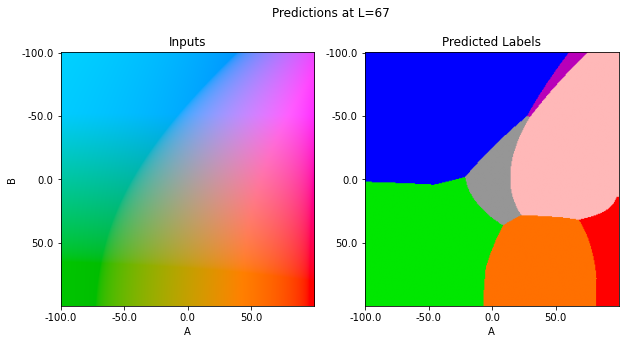

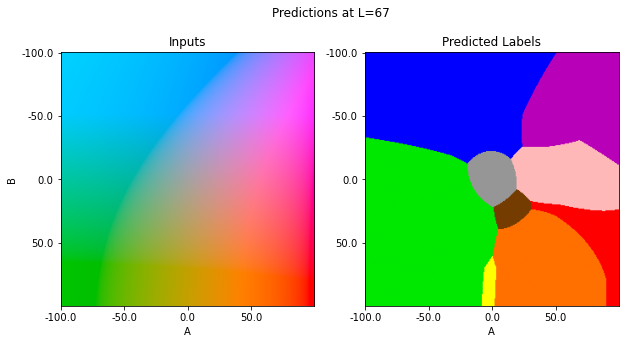

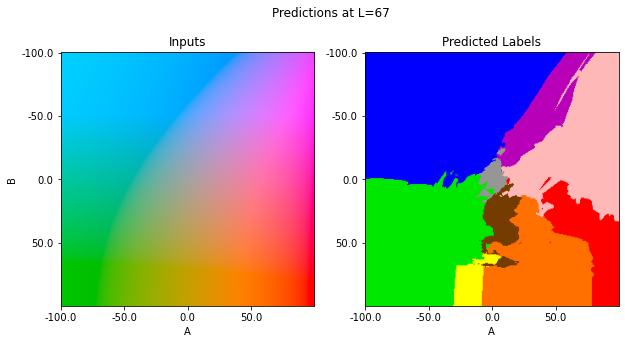

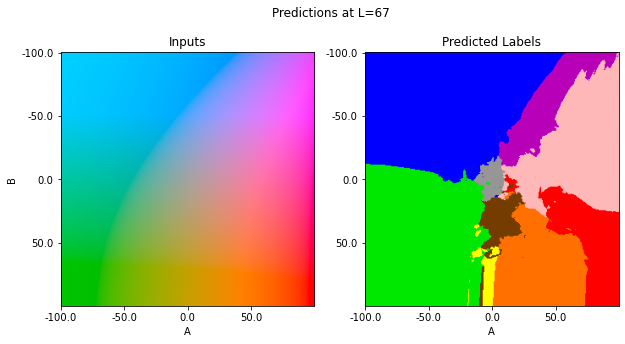

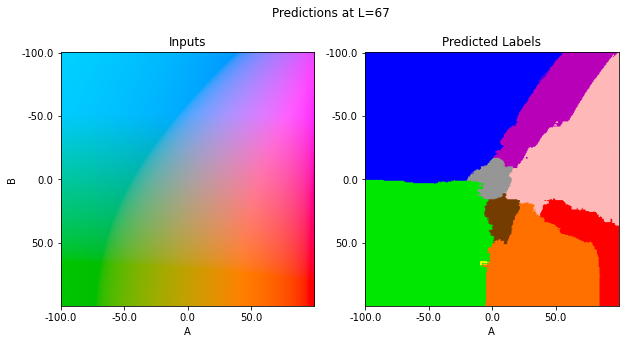

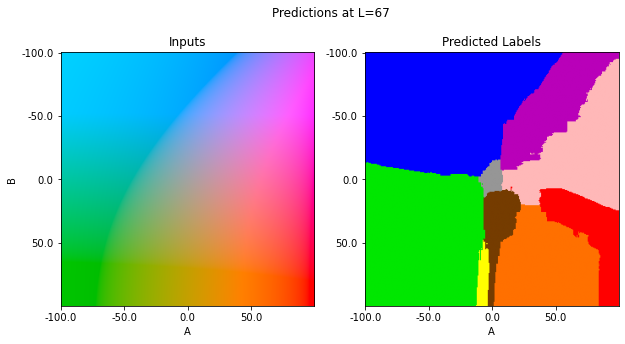

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

bayes_rgb_model = GaussianNB()
bayes_convert_model = make_pipeline(FunctionTransformer(convert_colors, validate=True), GaussianNB())

knn_rgb_model = KNeighborsClassifier(n_neighbors=5)
knn_convert_model = make_pipeline(FunctionTransformer(convert_colors, validate=True), KNeighborsClassifier(n_neighbors=5))

rf_rgb_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5)
rf_convert_model = make_pipeline(FunctionTransformer(convert_colors, validate=True), 
                                RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5))

models = [bayes_rgb_model, bayes_convert_model, knn_rgb_model, knn_convert_model, rf_rgb_model, rf_convert_model]
for i, m in enumerate(models):  # yes, you can leave this loop in if you want.
    m.fit(X_train, y_train)
    plot_predictions(m)
    plt.savefig('predictions-%i.png' % (i,))

print(OUTPUT_TEMPLATE.format(
    bayes_rgb=bayes_rgb_model.score(X_valid, y_valid),
    bayes_convert=bayes_convert_model.score(X_valid, y_valid),
    knn_rgb=knn_rgb_model.score(X_valid, y_valid),
    knn_convert=knn_convert_model.score(X_valid, y_valid),
    rf_rgb=rf_rgb_model.score(X_valid, y_valid),
    rf_convert=rf_convert_model.score(X_valid, y_valid),
))

In [9]:
data

,R,G,B,Label,Confidence
0,168,211,243,blue,good
1,37,32,40,black,perfect
2,35,34,38,black,perfect
3,79,74,159,purple,good
4,55,99,34,green,perfect
...,...,...,...,...,...
4373,75,140,79,green,perfect
4374,83,13,133,purple,perfect
4375,139,169,103,green,perfect
4376,173,34,214,purple,perfect
